# Identifying Credit Card Fraud

In [1]:
%matplotlib inline
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import lib.machine_learning as ml
import lib.data_preproc as pp
import lib.plots as plots

In [2]:
fraud_df = pd.read_csv('./data/Fraud_Data.csv')
ip_df = pd.read_csv('./data/IpAddress_to_Country.csv')
fraud_df = fraud_df.dropna()

In [3]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 13.8+ MB


In [4]:
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
fraud_df[fraud_df['class'] == 1].head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
24,171711,2015-01-11 01:51:15,2015-01-11 01:51:16,52,YPLQGKBAAULUV,Direct,IE,F,35,1.120619e+09,1
25,59780,2015-01-04 22:32:33,2015-01-16 01:13:43,31,WUMOBGUCBOXPO,SEO,FireFox,M,36,1.752167e+09,1
29,151705,2015-01-07 03:44:53,2015-01-07 03:44:54,48,URHCRIXOMLJMH,SEO,Chrome,F,27,2.836025e+09,1
59,345865,2015-02-01 05:59:23,2015-02-20 08:09:10,36,FKQPZUELCRKBL,SEO,IE,M,30,2.740590e+09,1


In [6]:
ip_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [7]:
countries = [None] * fraud_df.shape[0]
for i, ip in enumerate(fraud_df['ip_address']):
    if i % 10000 == 0: print(i)
    idx = ip_df['lower_bound_ip_address'].searchsorted(ip) - 1
    country = ip_df['country'][idx].values[0]
    countries[i] = country

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000


In [8]:
fraud_df.insert(fraud_df.shape[1] - 1, 'country', pd.Series(countries))
fraud_df = fraud_df.drop('ip_address', axis=1)
fraud_df.head(1)

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,Japan,0


In [9]:
from datetime import datetime

def time_difference(signup, purchase):
    time_difference = create_datetime(purchase) - create_datetime(signup)
    return time_difference.seconds

def create_datetime(time):
    year = int(time[:4])
    month = int(time[5:7])
    date = int(time[8:10])
    hour = int(time[11:13])
    minutes = int(time[14:16])
    seconds = int(time[17:19])
    return datetime(year, month, date, hour=hour, minute=minutes, second=seconds)

In [10]:
elapsed_time = [None] * fraud_df.shape[0]
for i, row in enumerate(fraud_df.itertuples()):
    elapsed_time[i] = time_difference(row.signup_time, row.purchase_time)

In [11]:
fraud_df.insert(3, 'elapsed_time', pd.Series(elapsed_time))
fraud_df.head(1)

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,source,browser,sex,age,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,Japan,0


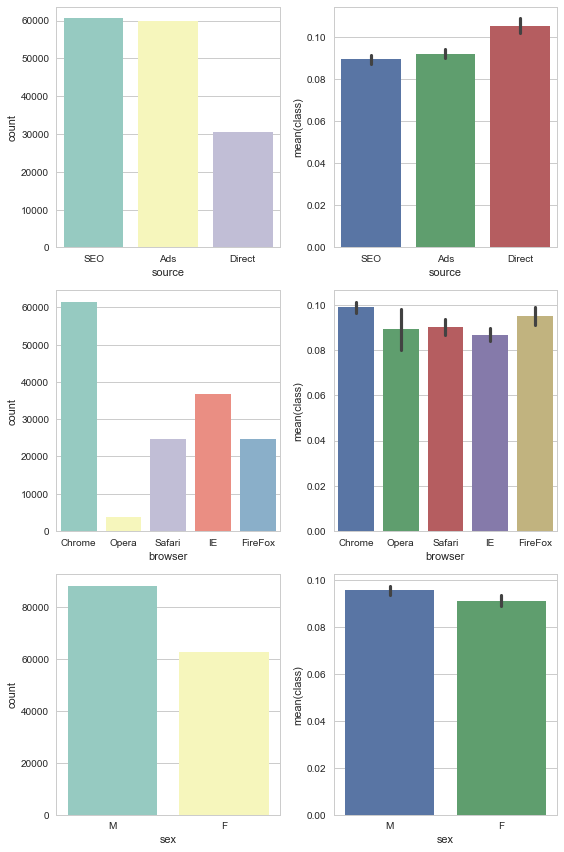

In [12]:
factors = ['source', 'browser', 'sex']
plots.factor_plot(fraud_df, factors, 'class')

In [13]:
uniques, indices, counts = np.unique(fraud_df['device_id'], return_inverse=True, return_counts=True)
device_uses = [None] * fraud_df.shape[0]
for i, index in enumerate(indices):
    device_uses[i] = counts[index]
fraud_df.insert(6, 'device_uses', pd.Series(device_uses))
fraud_df.head(1)

,user_id,signup_time,purchase_time,elapsed_time,purchase_value,device_id,device_uses,source,browser,sex,age,country,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,13882,34,QVPSPJUOCKZAR,1,SEO,Chrome,M,39,Japan,0


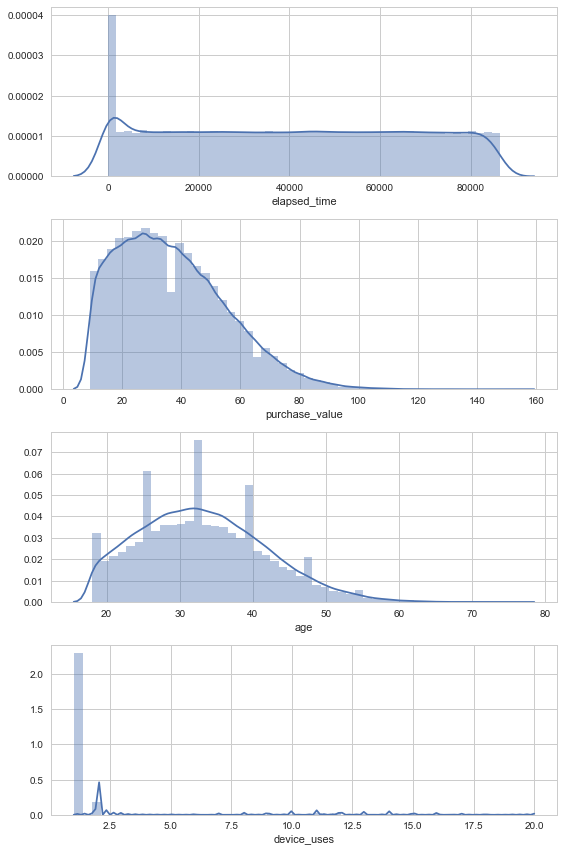

In [14]:
plots.continuous_plots(fraud_df, ['elapsed_time', 'purchase_value', 'age', 'device_uses'])

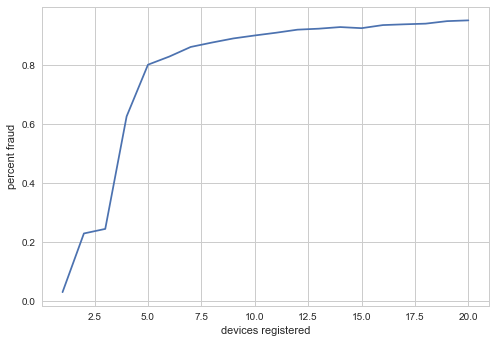

In [15]:
bins = np.arange(1, max(fraud_df['device_uses']) + 1)
counts = []
for x in bins:
    df_slice = fraud_df[fraud_df['device_uses'] == x]
    counts.append(df_slice['class'].mean())
    
plt.plot(bins, counts)
plt.xlabel('devices registered')
plt.ylabel('percent fraud')
plt.show()

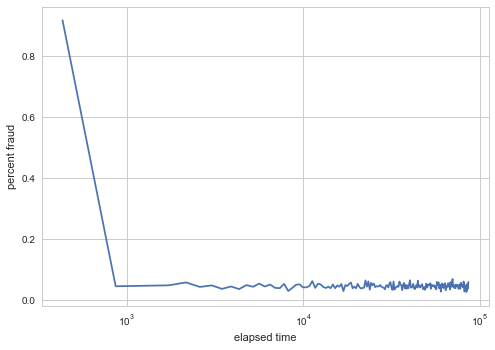

In [16]:
bins, step = np.linspace(0, max(fraud_df['elapsed_time']), 200, retstep=True)
bins = bins[1:]
values = [fraud_df[(fraud_df['elapsed_time'] >= edge - step) & 
                      (fraud_df['elapsed_time'] < edge)]['class'].mean() for edge in bins]
plt.plot(bins, values)
plt.xscale('log')
plt.xlabel('elapsed time')
plt.ylabel('percent fraud')
plt.show()

In [38]:
import math
def is_not_nan(val):
    if type(val) == float:
        return not math.isnan(val)
    return True
v_isnan = np.vectorize(is_not_nan)
fraud_df = fraud_df[v_isnan(fraud_df['country'])]

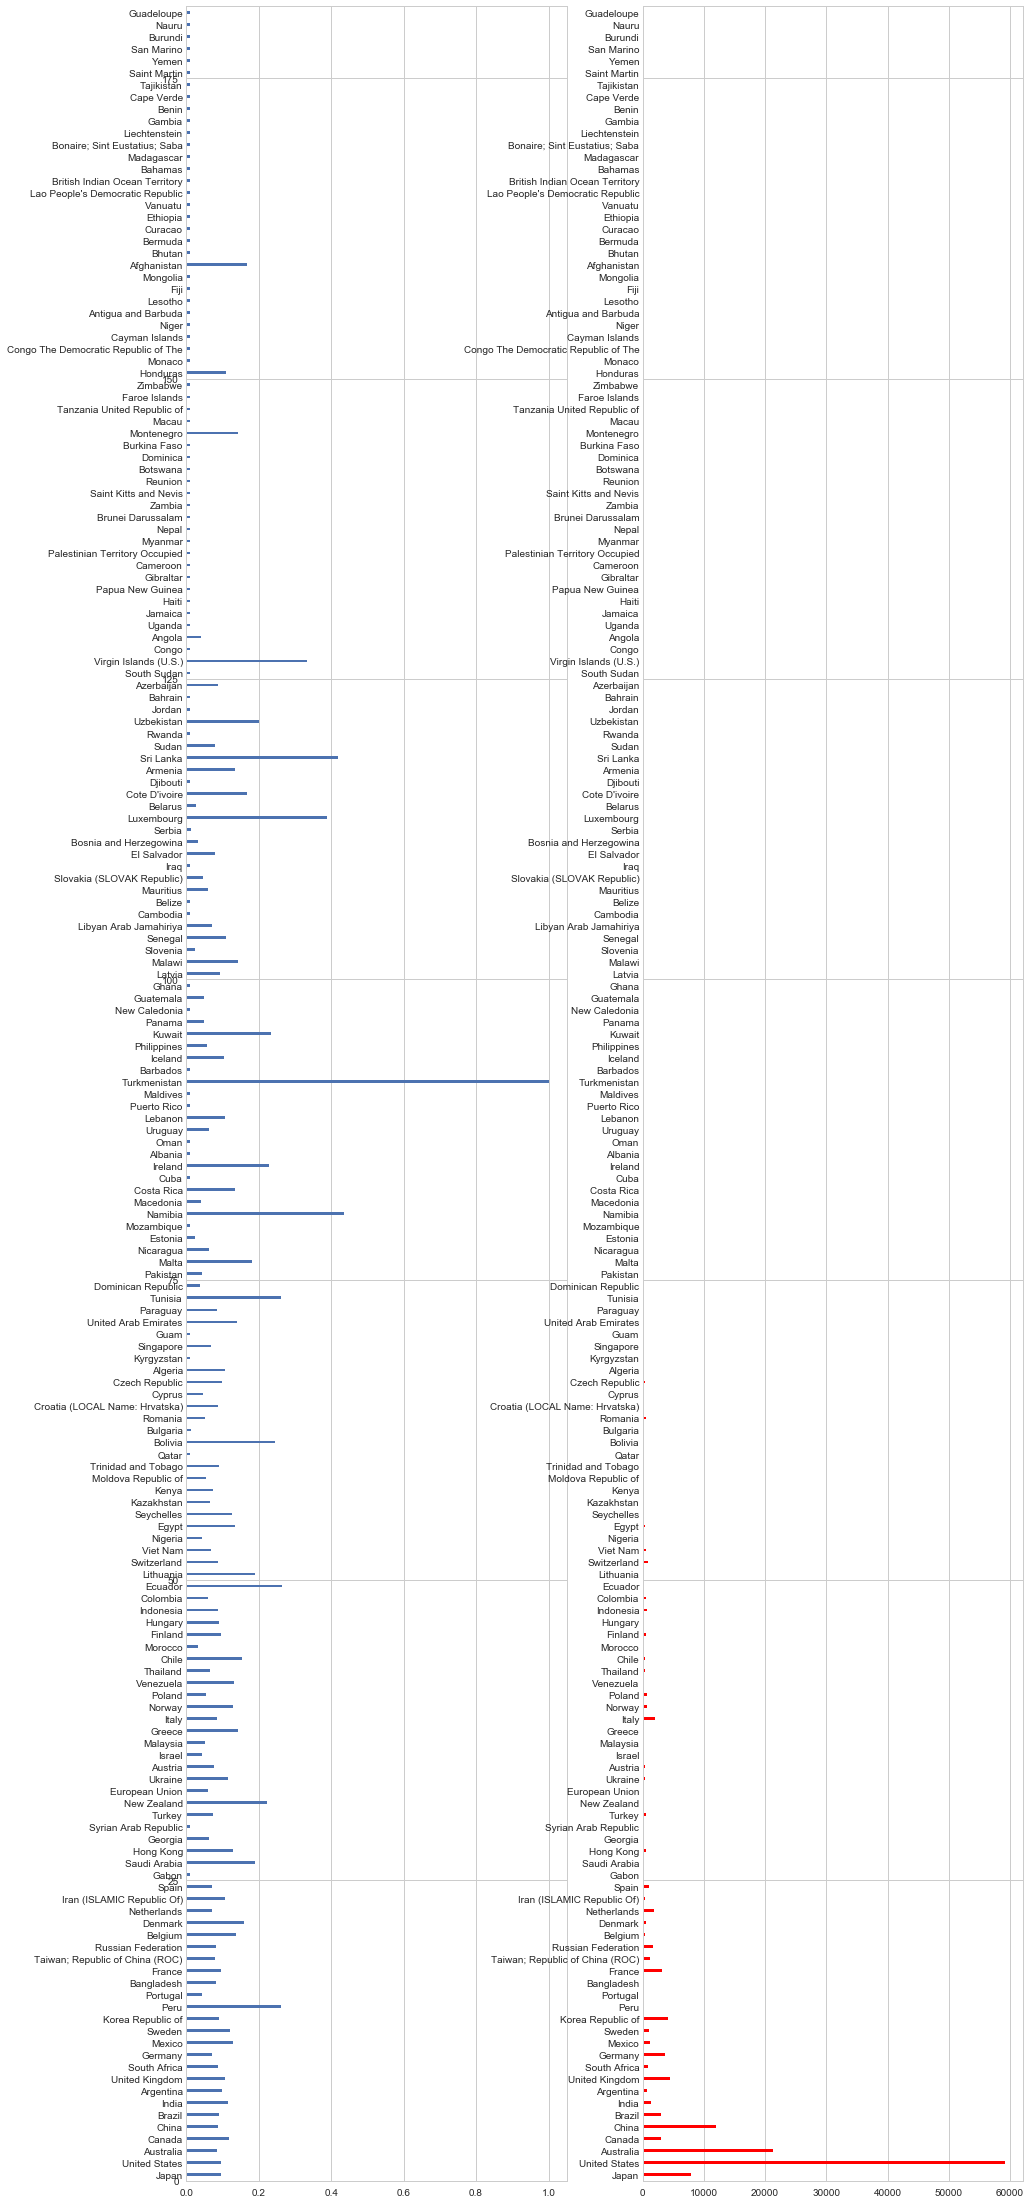

In [65]:
countries = fraud_df['country'].unique()

pos = np.arange(len(countries)) + 0.5
height = 40 / len(countries)

averages = []
counts = []
for country in countries:
    avg = fraud_df[fraud_df['country'] == country]['class'].mean()
    count = fraud_df[fraud_df['country'] == country].shape[0]
    if avg == 0: avg = 0.01
    averages.append(avg)
    counts.append(count)
    
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(15, 40))
# first plot

ax1.barh(pos, averages, height=height)
ax1.set_yticks(pos, minor=True)
ax1.set_yticklabels(countries, minor=True)
ax1.set_ylim(min(pos) - 0.5, max(pos) + 0.5)

# second plot
ax2.barh(pos, counts, height=height, color='r')
ax2.set_ylim(min(pos) - 0.5, max(pos) + 0.5)

plt.show()

In [40]:
# make a pie chart of where most fraud people are

181